In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2) 
%matplotlib inline
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж
              [500, 700, 750, 600, 1450,        # средняя стоимость занятия
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64) # квалификация репетитора

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]) # подходит или нет репетитор

In [3]:
def calc_std(x):
    return (x - x.mean()) / x.std()

def calc_mse(x):
    return np.mean((y - y_pred) ** 2)

def calc_norm(x):
    return (x - x.min()) / (x.max() - x.min())

X_st = X.copy()
X_st = calc_std(X)
X_norm = X.copy()
X_norm = calc_norm(X)

In [4]:
# def calc_logloss(y, y_pred): # Было
#     err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
#     return err

#### 1. *Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log (как вариант - np.clip).  

In [5]:
def calc_logloss(y, y_pred):
    err = np.mean(- y * np.log(np.clip(y_pred, 1e-8, np.inf)) - (1.0 - y) * np.log(11.0 - np.clip(y_pred, -np.inf, 1 - 1e-8)))
    return err

In [6]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [7]:
def eval_LR_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations + 1):
        
        y_pred = sigmoid(np.dot(w, X))
        err = calc_logloss(y, y_pred)    
    
        w -= alpha * (1/n * np.dot((y_pred - y), X.T))
        if i % (iterations / 10) == 0:
            print(i, w, err)
    return w

#### 2. Подберите аргументы функции eval_LR_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [60]:
def eval_LR_model2(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[0])
    n = X.shape[1]
    err = 0
    err_prev = np.inf
    
    for i in range(1, iterations + 1):        
        
        y_pred = sigmoid(np.dot(w, X))
        err = calc_logloss(y, y_pred) 
        w -= alpha * (1/n * np.dot((y_pred - y), X.T))
        
        if err > err_prev:
# #             print(err)
            return w, err
        err_prev = err
  
        
#         if i % (iterations / 10) == 0:
#             print(i, w, err)
    return w, err

In [86]:
# alpha = np.linspace(1e-3, 1e3, 100)
alpha = np.logspace(0, 2, num=100)

In [87]:
err_loglos = []
w_pred = []
for i in alpha:
    w, err = eval_LR_model2(X_st, y, iterations=100, alpha=i)
    err_loglos.append(err)
    w_pred.append(w)

In [88]:
np.abs(min(err_loglos))

0.8048813091480301

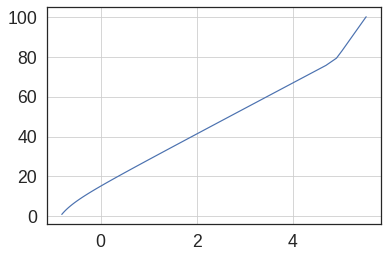

In [89]:
plt.plot(err_loglos, alpha);
plt.grid();

#### 3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются веса, которые уже посчитаны функцией eval_LR_model и X, на выходе - массив y_pred_proba).

In [78]:
def calc_pred_proba(w, x):
    return sigmoid(np.dot(w, x))

#### 4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются веса, которые уже посчитаны функцией eval_LR_model и X, на выходе - массив y_pred).

In [79]:
def calc_pred(w, x, line=0.5):
    calc_pred = list(map(lambda x: 1 if x > line else 0, calc_pred_proba(w, x)))
    return calc_pred


y_pred = calc_pred(w, X_st)
y_pred, y

([0, 0, 0, 0, 1, 0, 1, 1, 0, 1], array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]))

#### 5. Посчитайте accuracy, матрицу ошибок, precision и recall, а также F1-score.

In [80]:
accuracy = 100.0 - np.mean(np.abs(y_pred - y)*100.0)
accuracy

70.0

In [81]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y)):
    if y[i] == y_pred[i]:
        if y[i] == 1:
            tp += 1
        else:
            tn += 1
    else:
        if y[i] == 0:
            tn += 1
        else:
            fn += 1
conf_m = np.array([[tp, tn], [fp, fn]])
conf_m

array([[3, 5],
       [0, 2]])

In [82]:
precision=conf_m[0,0]/(conf_m[0,0]+conf_m[0,1])
precision

0.375

In [83]:
recall=conf_m[0,0]/(conf_m[0,0]+conf_m[1,0])
recall

1.0

In [84]:
F1=2*precision*recall/(precision+recall)
F1

0.5454545454545454

#### 6. Могла ли модель переобучиться? Почему?

#### Могла, так как recall = 1

#### 7. *Создайте функции eval_LR_model_l1 и eval_LR_model_l2 с применением L1 и L2 регуляризации соответственно.

In [85]:
def eval_LR_model_l1(X, y, alpha=1e-4, lambda_=1e-6):      
    np.random.seed(42)
    w = np.random.randn(X.shape[0])
    n = X.shape[1]
    err_prev = np.inf
    err = 0  
    while np.abs(err_prev - err) >= 1e-7:
        y_pred = sigmoid(np.dot(w, X))
        err_prev = calc_logloss(y, y_pred) 
        w -= alpha * (1/n * np.dot((y_pred - y), X.T)) + lambda_ * np.sign(w)
        if i % (iterations / 10) == 0:
            print(i, w, err)
    return w

def eval_LR_model_l2(X, y, alpha=1e-4, lambda_=1e-6):      
    np.random.seed(42)
    w = np.random.randn(X.shape[0])
    n = X.shape[1]
    err_prev = np.inf
    err = 0  
    while np.abs(err_prev - err) >= 1e-7:
        y_pred = sigmoid(np.dot(w, X))
        err_prev = calc_logloss(y, y_pred) 
        w -= alpha * (1/n * np.dot((y_pred - y), X.T)) + 2 * lambda_ * w
        if i % (iterations / 10) == 0:
            print(i, w, err)
    return w